In [3]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp
from sklearn.model_selection import StratifiedKFold
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as albu
import PIL

In [4]:
DATA_DIR = '/mnt/chicm/data/bengali'
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [5]:
df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet')
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [6]:
HEIGHT = 137
WIDTH = 236

def get_img(img_idx):
    return 255 - df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)

In [7]:
def get_img_tensor(img_idx):
    img = get_img(img_idx)
    return transforms.functional.to_tensor(img)

In [8]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    plt.figure(figsize=(30, 20))
    columns = 4
    for i, img in enumerate(imgs):
        plt.subplot(n / columns + 1, columns, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

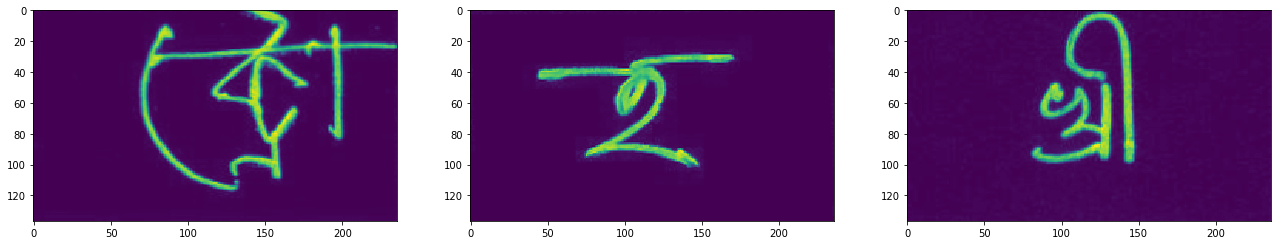

In [9]:
show_imgs([get_img(0), get_img(1), get_img(2)])

In [10]:
x = get_img_tensor(0)

In [11]:
x.size()

torch.Size([1, 137, 236])

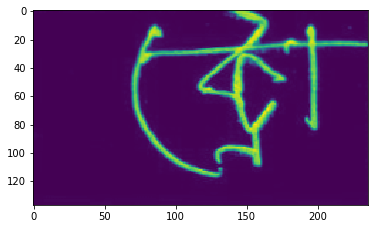

In [12]:
plt.imshow(transforms.functional.to_pil_image(x))

In [13]:
def get_train_augs(p=1.):
    return albu.Compose([
        #albu.HorizontalFlip(.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5 ),
        albu.Blur(blur_limit=3, p=0.3),
        albu.OpticalDistortion(p=0.3),
        albu.GaussNoise(p=0.3),
        albu.GridDistortion(p=1.),
        #albu.HueSaturationValue(p=.33) # not for grey scale
    ], p=p)
augs = get_train_augs()

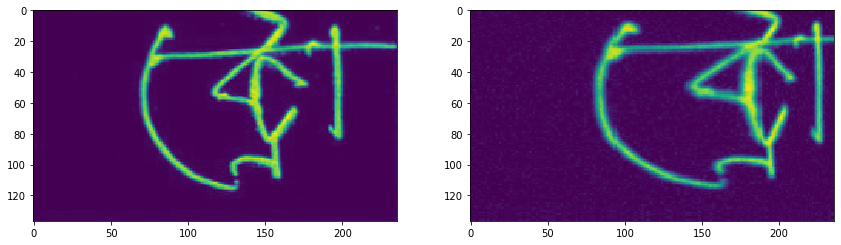

In [14]:
img = get_img(0)
img_aug = augs(image=img)['image']
show_imgs([img, img_aug])

In [274]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import pdb

class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
        if np.random.rand() > self.prob:
            return img
        h = img.size(1)
        w = img.size(2)
        hh = int(1.5*h)
        ww = int(1.5*w)
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
        self.l = int(d*self.ratio+0.5)
        mask = np.ones((hh, ww), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, ww//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, ww), 0)
                t = max(min(t, ww), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (ww-w)//2:(ww-w)//2+w]

        mask = torch.from_numpy(mask).float().cuda()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        img = img * mask 

        return img

class GridMask(nn.Module):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.6, mode=1, prob=1.):
        super(GridMask, self).__init__()
        self.rotate = rotate
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.grid = Grid(d1, d2, rotate, ratio, mode, prob)

    def set_prob(self, epoch, max_epoch):
        self.grid.set_prob(epoch, max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        n,c,h,w = x.size()
        y = []
        for i in range(n):
            y.append(self.grid(x[i]))
        y = torch.cat(y).view(n,c,h,w)
        return y


In [275]:
grid = GridMask(64, 128, rotate=15)

In [276]:
img = get_img_tensor(1).unsqueeze(0).cuda()
x = grid(img)

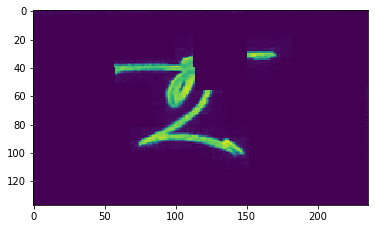

In [277]:
plt.imshow(transforms.functional.to_pil_image(x[0].cpu()))

In [175]:
np.random.randint(10)

0

In [278]:
x.shape

torch.Size([1, 1, 137, 236])